In [60]:
using Plots
include("TDCM_modelling.jl")

In [61]:
using RCall

R"""
load("TDCM_Multilevel_data_three_skills.RData")
"""
TDCM_data = @rget data
Y = Array{Int, 3}(TDCM_data[:Y])
Q = convert(Matrix{Int64}, TDCM_data[:Q_matrix])
U = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_group])
for skill in TDCM_data[:X_ind]
    for time in 1:length(skill)
        if skill[time] isa Vector{<: Number}
            skill[time] = reshape(skill[time], :, 1)
        end
    end
end
X = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_ind])
group = Vector{Int64}(TDCM_data[:group])
obs = TDCMObs(Y, Q, U, X, group)

# R"""
# load("TDCM_multilevel_J50_data.RData")
# """
# TDCM_J50_data = @rget data_large_questions
# Y = Array{Int, 3}(TDCM_J50_data[:Y])
# Q = convert(Matrix{Int64}, TDCM_J50_data[:Q_matrix])
# U = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_group])
# for skill in TDCM_J50_data[:X_ind]
#     for time in 1:length(skill)
#         if skill[time] isa Vector{<: Number}
#             skill[time] = reshape(skill[time], :, 1)
#         end
#     end
# end
# X = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_ind])
# group = Vector{Int64}(TDCM_J50_data[:group])
# obs_J50 = TDCMObs(Y, Q, U, X, group)
;

In [62]:
N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)

mu_beta_prior = Vector{Vector{Float64}}(undef, J)
L_beta_prior = Vector{Matrix{Float64}}(undef, J)
for j in 1:J
    num_features = size(obs.D[j], 2)
    mu_beta_prior[j] = zeros(num_features)
    L_beta_prior[j] = Matrix(1.0I, num_features, num_features)
end

mu_omega_prior = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, K)
L_omega_prior = Vector{Vector{Vector{Vector{Matrix{Float64}}}}}(undef, K)
a_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)
b_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)

for k in 1:K
    mu_omega_prior[k] = Vector{Vector{Vector{Vector{Float64}}}}(undef, O)
    L_omega_prior[k] = Vector{Vector{Vector{Matrix{Float64}}}}(undef, O)
    a_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    b_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    for t in 1:O
        num_features_gamma = size(obs.X[k][t], 2)
        num_features_omega = size(obs.U[k][t], 2)
        if t == 1
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 1)
            mu_omega_prior[k][t][1] = Vector{Vector{Float64}}(undef, 1)
            mu_omega_prior[k][t][1][1] = zeros(num_features_omega)

            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 1)
            L_omega_prior[k][t][1] = Vector{Matrix{Float64}}(undef, 1)
            L_omega_prior[k][t][1][1] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)

            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            a_tau_prior[k][t][1] = [.01]

            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            b_tau_prior[k][t][1] = [.01]
        else
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 2)
            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 2)
            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            for z in 1:2
                mu_omega_prior[k][t][z] = Vector{Vector{Float64}}(undef, num_features_gamma)
                L_omega_prior[k][t][z] = Vector{Matrix{Float64}}(undef, num_features_gamma)
                a_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                b_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                for m in 1:num_features_gamma
                    mu_omega_prior[k][t][z][m] = zeros(num_features_omega)
                    L_omega_prior[k][t][z][m] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)
                end
            end
        end
    end
end

M = 100
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)

# J50 = size(obs_J50.Y, 3)
# mu_beta_prior = Vector{Vector{Float64}}(undef, J50)
# V_beta_prior = Vector{Matrix{Float64}}(undef, J50)
# for j in 1:J50
#     num_features = size(obs_J50.D[j], 2)
#     mu_beta_prior[j] = zeros(num_features)
#     V_beta_prior[j] = Matrix(1.0I, num_features, num_features)
# end
# model_J50 = TDCModel(obs_J50, mu_beta_prior, V_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=false)
;

TDCModel constructed for computation on 12 threads


In [48]:
# @resumable pi_t1_loglike = function(Z :: Vector{Int}, Y, :: Vector{Int}, D_beta :: Vector{AbstractFloat})
#     for m in 1:model.M
#         J = size(Y)
#         log_prob_YZ = 0
#         for j in 1:J
#             mul!(D_beta, D[j], beta_sample[j][m])
#             log_prob_YZ += dot(z_im, log.(sigmoid.((2*Y[i, 1, j] - 1) .* D_beta)))
#         end
#         skill_profile = obs.skill_dict[argmax(z_im)]
#         for k in 1:K
#             log_prob_YZ += log(sigmoid((2*skill_profile[k] - 1) * dot(gamma_sample[k][1][1][group_i][m], obs.X[k][1][i])))
#         end
#     end
# end

**Estimating attribute profiles from uniform initialization**

In [56]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [57]:
# Fix true values of gamma and betas
for k in 1:K
    for s in S
        model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
        model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
    end
end

# Initialize in correct direction
for j in 1:J
    # model.mu_beta_star[j] = cat(-1, ones(length(model.mu_beta_star[j]) - 1), dims=1)
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] ./ 100
end

# Sample beta and gammas
sample_β(model)
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

In [58]:
for i in 1:50
    update_categorical_variational_distribution(model, step=.02, maxiter=1, verbose=false)
    update_categorical_variational_distribution2(model, 2, step=.02, maxiter=1, verbose=false)
    update_normal_variational_distribution(model, init_step = .06, maxiter = 3, verbose = false)
end

In [59]:
# skill_profiles = Dict(1=>[0, 0], 
#                  2=>[0, 1],
#                  3=>[1, 0],
#                  4=>[1, 1])

# skill_numbers = Dict([0, 0]=>1, 
#                  [0, 1]=>2,
#                  [1, 0]=>3,
#                  [1, 1]=>4)
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)


preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][1])]
    actual = Vector{Int}(data[:profiles][i, :, 1])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [60]:
attribute_accs

8-element Vector{Float64}:
 0.912
 0.8484398216939079
 0.895500725689405
 0.9709864603481625
 0.9453978159126365
 0.9198473282442748
 0.962457337883959
 0.9959595959595959

In [61]:
preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [62]:
attribute_accs

8-element Vector{Float64}:
 0.9142857142857143
 0.8970099667774086
 0.8923076923076924
 0.9761904761904762
 0.953405017921147
 0.9442508710801394
 0.9470899470899471
 0.9973172367538564

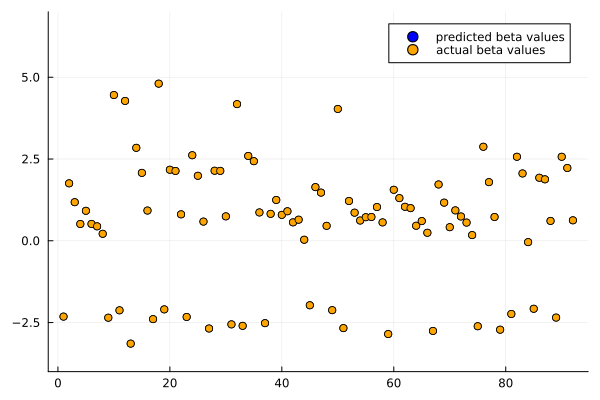

In [63]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

**Estimating Item response parameters with correct attribute profiles**

In [4]:
M = 500
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 12 threads


In [5]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

In [11]:
res = update_normal_variational_distribution(model, init_step = .01, maxiter = 300, verbose = false)

([-1.2363511035998873 0.5226927959881882 … 0.6627915605380494 0.6236314482997456; -1.2501574988157689 0.5222759959745794 … 0.6624154758737839 0.6237121646908051; … ; -1.886368652843378 0.4114899226003745 … 0.59244290428979 0.6865246966717886; -1.8814905342975017 0.41730533664780944 … 0.5912000331677075 0.6863797248932992], [0.01233938739394457 0.04230676778527996 … 0.5006018108313609 0.6899104725634707; 0.010341898618100932 0.03822703044244413 … 0.4930807081700194 0.6943544252164864; … ; 6.978919018595084e-5 0.006092275221028983 … 0.49678995916241464 0.7754991800885732; 3.188058566478644e-5 0.007378470411601094 … 0.4979931058788098 0.779394227223819], [-4763.243303999195, -4741.886479685399, -4720.877615991944, -4684.846669784031, -4691.100047942911, -4726.047813594049, -4702.1669288599405, -4674.975782818276, -4667.418808501409, -4668.655130960931  …  -4521.04444904091, -4496.757851474684, -4487.614538693663, -4495.34316995452, -4503.998331894484, -4524.083207815018, -4532.96594006590

In [12]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

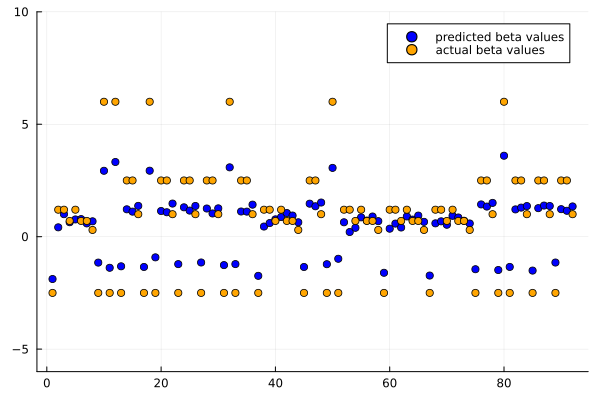

In [13]:
using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-6, 10)

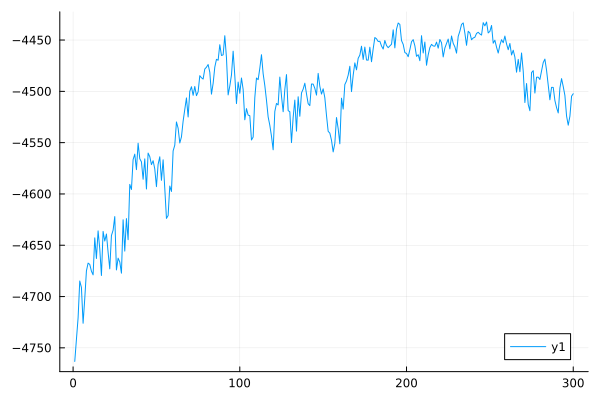

In [16]:
plot(1:300, res[3])

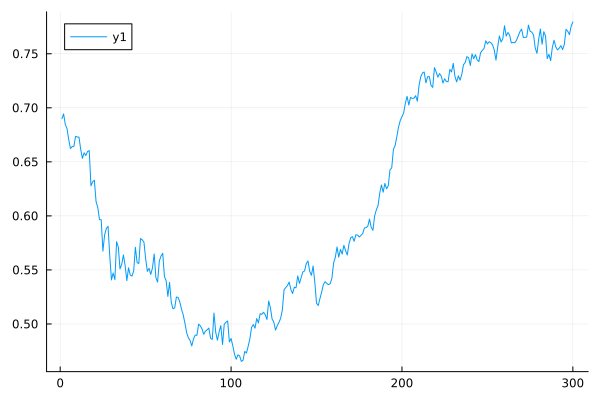

In [17]:
plot(1:300, res[2][:,8])

In [198]:
res[2][:,1]

50-element Vector{Float64}:
 1.0
 0.46972340797246115
 0.20359157713101814
 0.07720032165792379
 0.035401522465259516
 0.057801179405345446
 0.03648680603990635
 0.0023565216171795565
 0.0005730139172568857
 1.4973827902050452e-5
 3.385136237510138e-5
 0.00619742708250153
 0.0002895501452765877
 ⋮
 2.4952091359234544e-7
 5.136532792048222e-5
 0.0007362666966913028
 0.0011578130197035794
 0.0004177293953358412
 0.0007792124786464299
 0.00025123986698000016
 0.0009932028074458048
 0.00031739371538869193
 1.925744293327319e-7
 1.4432647465306893e-7
 9.456247913447866e-7

**Estimating gamma with correct attribute profiles, gamma, and tau**

In [63]:
M = 200
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 12 threads


In [64]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Fix true values of omega and make tau small
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 100
                model.a_tau_star[k][t][1][feature] = 50
                model.b_tau_star[k][t][1][feature] = 2
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./ 100
                    model.a_tau_star[k][t][z + 1][feature] = 50
                    model.b_tau_star[k][t][z + 1][feature] = 2
                end
            end
        end
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [71]:
res = update_normal_variational_distribution2(model, init_step = .001, maxiter = 5000, verbose = false);

In [72]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

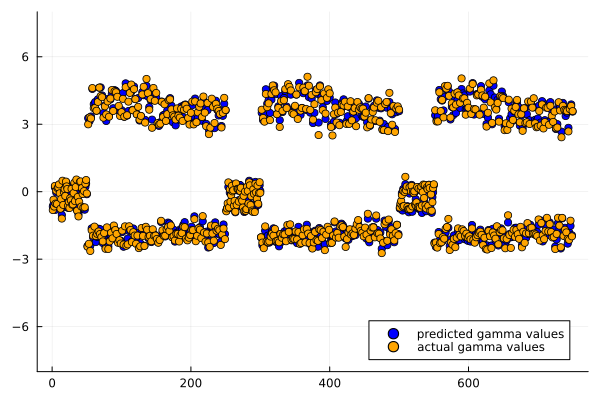

In [73]:
using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

In [74]:
model.V_gamma_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.6789759999999996;;], [0.35046399999999944;;], [0.7259039999999995;;], [0.5040999999999994;;], [18.48999999999802;;], [0.7224999999999996;;], [0.4596839999999995;;], [0.5928999999999995;;], [0.7191039999999996;;], [19.30723599999825;;]  …  [0.39187599999999945;;], [0.3091359999999994;;], [0.6146559999999995;;], [0.46785599999999944;;], [0.4596839999999995;;], [0.5241759999999995;;], [0.6528639999999996;;], [0.5898239999999995;;], [0.5270759999999994;;], [0.5446439999999995;;]]], [[[0.3215144255576054 -0.04257817263471619; -0.04257817263471619 0.29099661736089466], [0.24281205328225722 0.004304834354921249; 0.004304834354921249 0.4357995889700907], [0.38568333625031787 0.10908104104240318; 0.10908104104240318 0.8451410135339131], [0.2706772785465253 0.03354196550088684; 0.03354196550088684 0.18836502007175085], [24.433725034942995 5.3545838683231946; 5.3545838683231946 18.387996876675015], [0.3259463707278941 -0.0533475623

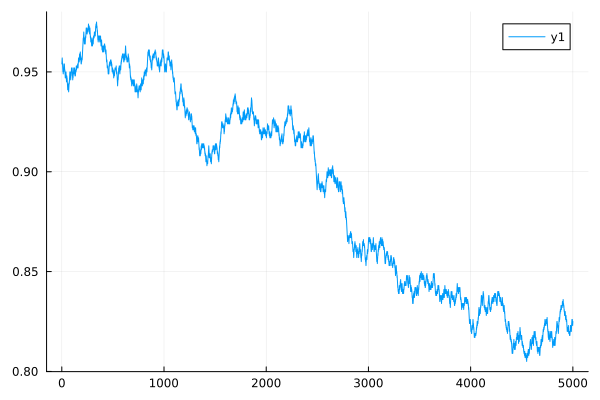

In [75]:
plot(1:5000, res[2])

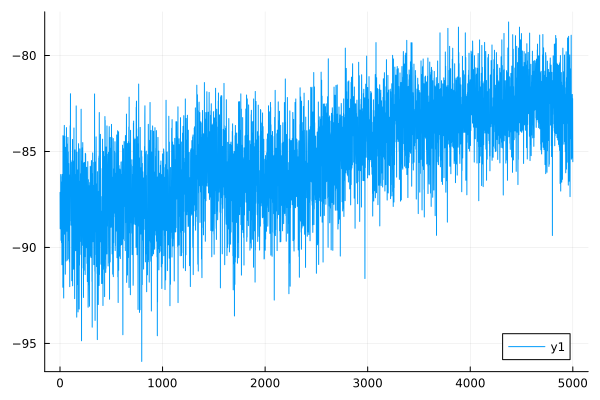

In [76]:
plot(1:5000, res[3])

**Estimating omega with correct gamma**

In [68]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 12 threads


In [69]:
# Fix true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] ./ 100
                end
            end
        end
    end
end


# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample tau
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [85]:
update_normal_variational_distribution3(model, init_step = .1, maxiter = 800, verbose = false)

In [86]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

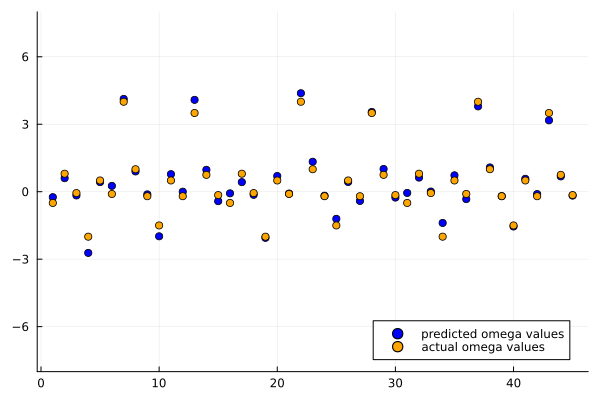

In [87]:
using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

In [88]:
model.V_omega_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.10655736805490108 0.11111318230359273 -0.0360293008673438; 0.11111318230359273 0.13961863219009957 -0.05021463617728482; -0.0360293008673438 -0.05021463617728482 0.05945721003238033]]], [[[0.38037080633901926 -0.22605360714210074 -0.13038890778196083; -0.22605360714210074 0.22250306477110612 0.06120634612853431; -0.13038890778196083 0.06120634612853431 0.1014072861141229], [0.4654104487498493 0.6417068376350279 -0.2525628705100468; 0.6417068376350279 0.9055420274180056 -0.30778573809073323; -0.2525628705100468 -0.30778573809073323 0.21586952974816437]], [[0.4804689650147462 0.007780821352348815 -0.12461918619781417; 0.007780821352348815 0.015400502915363165 0.011165812574968757; -0.12461918619781417 0.011165812574968757 0.04712590910027853], [0.26896706159873207 -0.06691514567064634 -0.12970004178096262; -0.06691514567064634 0.21841547573527903 -0.035684712487470585; -0.12970004178096262 -0.035684712487470585 0.095991282

**Estimate Attribute profile, Gamma, and Omega simultaneously**

In [102]:
M = 100
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 12 threads


In [103]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Fix true value of mu_beta
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] ./ 100
end

# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] .= model.V_gamma_star[k][1][1][s] ./ 40
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] .= model.V_gamma_star[k][t][z + 1][s] ./ 40
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 10
                model.a_tau_star[k][t][1][feature] = 50
                model.b_tau_star[k][t][1][feature] = 2
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./ 10
                    model.a_tau_star[k][t][z + 1][feature] = 50
                    model.b_tau_star[k][t][z + 1][feature] = 2
                end
            end
        end
    end
end

# Sample Z
for i in 1:N
    sample_Z(model, i, 1)
    sample_Z(model, i, 2)
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [61]:
res = update_normal_variational_distribution2(model, init_step = .01, maxiter = 1500, verbose = false)

([0.0, -0.01, -0.02, -0.03, -0.04, -0.030000000000000002, -0.04, -0.05, -0.060000000000000005, -0.07  …  -0.6000000000000003, -0.5900000000000003, -0.6000000000000003, -0.6100000000000003, -0.6200000000000003, -0.6100000000000003, -0.6000000000000003, -0.5900000000000003, -0.6000000000000003, -0.6100000000000003], [0.15811388300841897, 0.16811388300841898, 0.178113883008419, 0.188113883008419, 0.198113883008419, 0.20811388300841901, 0.21811388300841902, 0.20811388300841901, 0.21811388300841902, 0.22811388300841903  …  2.1981138830084164, 2.1881138830084166, 2.1981138830084164, 2.1881138830084166, 2.178113883008417, 2.1881138830084166, 2.178113883008417, 2.1881138830084166, 2.1981138830084164, 2.208113883008416], [-916.0283031867458, -901.7112358871939, -913.0117843862678, -896.723883468187, -878.664208674154, -894.5108499957786, -935.5580697406374, -879.8710644374868, -880.1825784988367, -885.9045863027035  …  -2812.2263242224662, -2774.3448635693603, -3036.946789570187, -3967.71005454

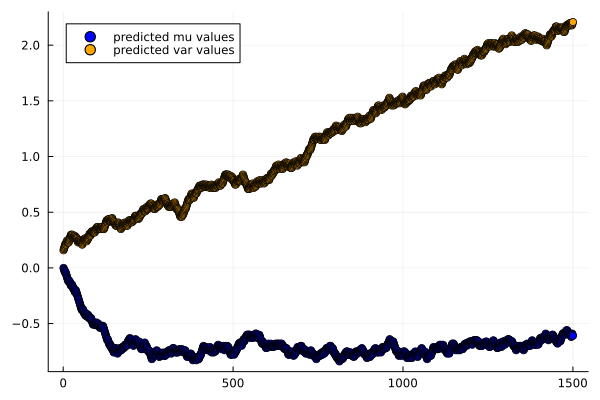

In [62]:
x = 1:1500
plot(x, res[1], seriestype=:scatter, label = "predicted mu values", mc=:blue)
plot!(x, res[2], seriestype=:scatter, label = "predicted var values", mc=:orange)

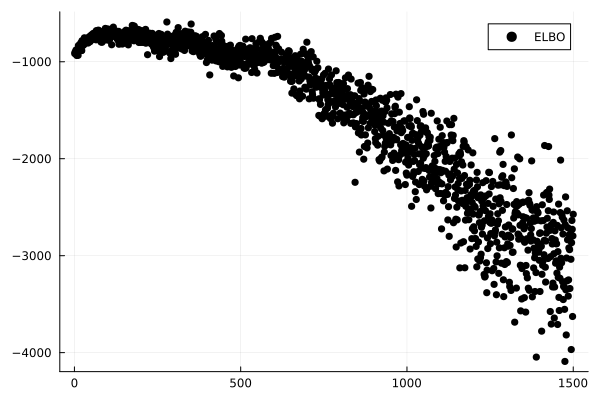

In [63]:
plot(x, res[3], seriestype=:scatter, label = "ELBO", mc=:black)

In [57]:
mean(diff(res[2]) .< 0)

0.4389593062041361

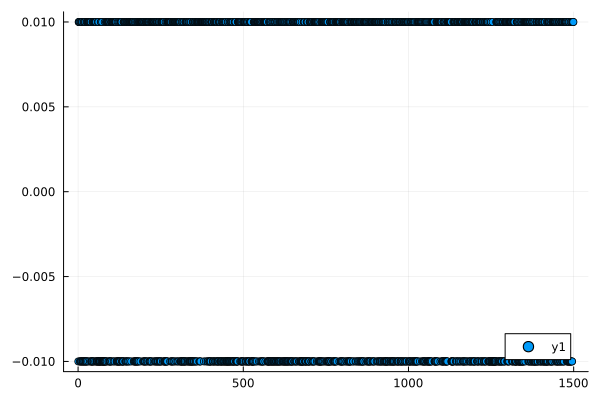

In [58]:
plot(1:1499, diff(res[2]), seriestype=:scatter)

In [109]:
for iter in 1:200
    # update_categorical_variational_distribution(model, maxiter=1, verbose=false)
    # for i in 1:N
    #     sample_Z(model, i, 1)
    # end

    # update_categorical_variational_distribution2(model, 2, maxiter=1, verbose=false)
    # for i in 1:N
    #     sample_Z(model, i, 2)
    # end
    update_normal_variational_distribution2(model, init_step = .01, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end

    update_normal_variational_distribution3(model, init_step = .01, maxiter = 100, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_ω(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_ω(model, k, t, z, feature)
                    end
                end
            end
        end
    end

    # update_inverse_gamma_distribution(model, step = 1e-6, maxiter = 30, verbose = false)
    # for k in 1:K
    #     for t in 1:O
    #         num_features = length(model.gamma_sample[k][t][1][1][1])
    #         if t == 1
    #             for feature in 1:num_features
    #                 sample_τ(model, k, t, 0, feature)
    #             end
    #         else
    #             for z in 0:1
    #                 for feature in 1:num_features
    #                     sample_τ(model, k, t, z, feature)
    #                 end
    #             end
    #         end
    #     end
    # end
end

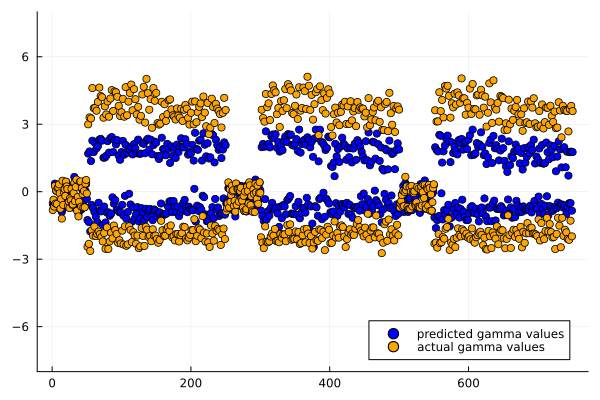

In [110]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

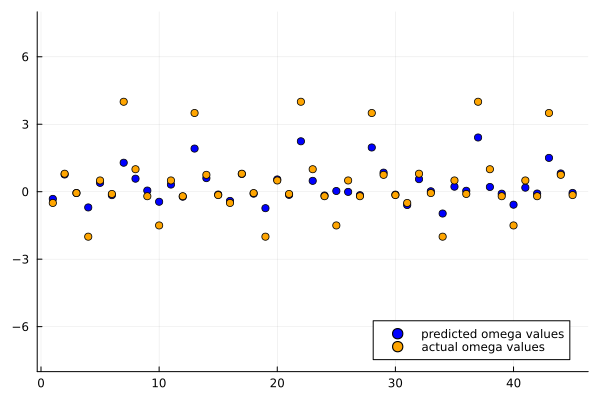

In [111]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

In [112]:
model.V_omega_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.011540097300107367 0.0021084317952729816 -0.005767486854624487; 0.0021084317952729816 0.0025570864678515592 -0.002939134381180543; -0.005767486854624487 -0.002939134381180543 0.005213614780700225]]], [[[0.001647457812040867 -0.00348353820550057 -0.0001282746153058382; -0.00348353820550057 0.02000123692571377 -0.0007737298924082179; -0.0001282746153058382 -0.0007737298924082179 0.003171357127443001], [0.0015363398750022701 -0.008577381232615868 0.0034103437905508727; -0.008577381232615868 0.05270352629635281 -0.018667008894382536; 0.0034103437905508727 -0.018667008894382536 0.008382489307801248]], [[0.04847898333321831 -0.005052041616146186 0.0040195640804067375; -0.005052041616146186 0.03459676866377315 -0.001941852292484979; 0.0040195640804067375 -0.001941852292484979 0.0004029745617770983], [0.007105596164200243 -0.011220799533598176 0.001257344326617355; -0.011220799533598176 0.0181511667328691 -0.0027908349049758714;

In [113]:
model.V_gamma_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.00047900211696917184;;], [0.020131670194948624;;], [0.0017544467966324145;;], [0.0014526680779794524;;], [0.03308255955427511;;], [0.00047900211696917097;;], [0.000479002116969174;;], [0.00032811275764268777;;], [0.0014526680779794418;;], [0.001452668077979446;;]  …  [0.013950889359326465;;], [3.5574373059312222e-6;;], [0.0014526680779794444;;], [0.0038298914762956503;;], [0.0017544467966324087;;], [0.00047900211696917216;;], [0.019075444679663222;;], [3.557437305930489e-6;;], [0.0004790021169691682;;], [0.003829891476295645;;]]], [[[0.07609350683212429 -0.07402089007976667; -0.07402089007976667 0.07264833931941107], [2.152928591344274 0.3360144685836995; 0.3360144685836995 0.055061755217154354], [0.02886095772902214 -0.1852241970714559; -0.1852241970714559 1.1887341453743614], [0.24244262955200468 -0.23585385423327068; -0.23585385423327068 0.23106603946716273], [0.16927880308096147 -0.5553415073697376; -0.55534150736973

In [89]:
model.tau_sample

3-element Vector{Vector{Vector{Vector{Vector{Float64}}}}}:
 [[[[0.04380632805708367, 0.03754617516716123, 0.041198502964542055, 0.03358094980016721, 0.042444471940306726, 0.034583857021282, 0.045481489098869066, 0.04086781602938361, 0.02709358940281516, 0.04229896908992582  …  0.03401376444525767, 0.051322608525909044, 0.041872299872422955, 0.04119088759515207, 0.03998859943401588, 0.03698749321898315, 0.039663121821210824, 0.035713683047907306, 0.04691291706530896, 0.03857491464323799]]], [[[0.04601984115109581, 0.030502319910462795, 0.0339593107821378, 0.04004008464926634, 0.033753970087939816, 0.04353715730503797, 0.03869425417310628, 0.040945380512730375, 0.045056179230167054, 0.05867411458651921  …  0.05482556502266734, 0.04017656074908584, 0.0385850921129546, 0.03756093853661679, 0.03065596955960358, 0.040732209255017665, 0.04125051010959004, 0.048809264014689796, 0.04280096030402075, 0.04571557923811385], [0.03509126544779638, 0.03802095934618525, 0.042444449763167136, 0.0326323

**Estimating Tau with true value of omega and gamma**

In [27]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [36]:
# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] .= model.V_gamma_star[k][1][1][s] ./30
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] .= model.V_gamma_star[k][t][z + 1][s] ./30
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 30
                #model.a_tau_star[k][t][1][feature] = 10
                #model.b_tau_star[k][t][1][feature] = .01
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./30
                    #model.a_tau_star[k][t][z + 1][feature] = 10
                    #model.b_tau_star[k][t][z + 1][feature] = .01
                end
            end
        end
    end
end

# # Initialize true values of tau
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = S/2
#                 model.b_tau_star[k][t][1][feature] = (S/2 - 1) * .04
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = S/2
#                     model.b_tau_star[k][t][z + 1][feature] = (S/2 - 1) * .04
#                 end
#             end
#         end
#     end
# end

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end



In [37]:
# for iter in 1:100
#     update_inverse_gamma_distribution(model, step = 1e-4, maxiter = 30, verbose = true)
#     for k in 1:K
#         for t in 1:O
#             num_features = length(model.gamma_sample[k][t][1][1][1])
#             if t == 1
#                 for feature in 1:num_features
#                     sample_τ(model, k, t, 0, feature)
#                 end
#             else
#                 for z in 0:1
#                     for feature in 1:num_features
#                         sample_τ(model, k, t, z, feature)
#                     end
#                 end
#             end
#         end
#     end
# end
update_inverse_gamma_distribution(model, step = 1e-4, maxiter = 2500, verbose = true)

ELBO: -28.76310894313251
b*: 73.46274782350909
ELBO: -27.8317095331211
gradient log(b*): -38.787997645389254
ELBO: -57.8692710427161
ELBO: -59.82869850294966
b*: 72.54933822857768
ELBO: -59.57358923934806
gradient log(b*): -19.278201501755024
b*: 235.35258554378814
gradient log(b*): -73.55642902718336
b*: 264.67558715863635
ELBO: -55.243158914077995
gradient log(b*): -3.6421093176842083
ELBO: -28.34440720756931
b*: 263.2627231716264
ELBO: -57.02700674159998
b*: 233.6277673186014
gradient log(b*): -37.629934149245756
gradient log(b*): -29.69946447113154
b*: 226.11907799560768
b*: 72.40961088033208
gradient log(b*): 17.700172633312526
gradient log(b*): -32.48444690844713
ELBO: -27.99921174473729
ELBO: -60.411573964691726
b*: 264.5792069688457
gradient log(b*): -59.130530173270586
b*: 73.17835244747033
gradient log(b*): -16.9837047425265
ELBO: -56.96487607843468
b*: 232.75027959434598
gradient log(b*): -33.83814480685877
ELBO: -27.536248037593985
b*: 72.17477389828318
ELBO: -59.2765785390

Excessive output truncated after 524293 bytes.

gradient log(b*): -20.78483816346831
gradient log(b*): -13.107057069916298
gradient log(b*): -14.326132515548725
ELBO: -2.9164779653467314
gradient log(b*): -18.895355667493877
b*: 25.04780475791998
ELBO: 1.0655789114833512
gradient log(b*): -22.989414090485187
b*: 21.270150493119456
gradient log(b*): -24.872750073635583
ELBO: -0.9128525504146857
b*: 22.842788793038448
ELBO: 23.210182212992443
b*: 7.027526234886779
gradient log(b*): -17.279329614670676
gradient log(b*): -20.673369408152944
ELBO: 22.665584816014164
b*: 7.435596748143748
gradient log(b*): -19.15208317902059
ELBO: 2.3411907946086337
b*: 21.024337128712215
gradient log(b*): -26.62419706112035
ELBO: -2.62223140187439
b*: 24.990287462134944
ELBO: 1.092293317405506
gradient log(b*): -22.246853101630457
b*: 21.21731151916558
ELBO: 22.60331872090682
b*: 7.4213696596710035
ELBO: -1.0780911336579655
gradient log(b*): -20.05033965534945
b*: 22.795613832006847
gradient log(b*): -15.701370583213382
ELBO: 1.3663294730829154
b*: 20.96

In [34]:
update_inverse_gamma_distribution_va(model)

In [38]:
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end
mean(model.tau_sample[2][2][1][2])

0.1766766364616565

In [39]:
model.a_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [40]:
model.b_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[2.3681007816235304]], [[2.3702876907359554, 3.794422887833501], [2.4628769709861396, 2.7068913255937894]]]
 [[[2.1758986604781922]], [[2.488155736819653, 4.215812415266939], [2.281293200404011, 3.5601861029816533]]]

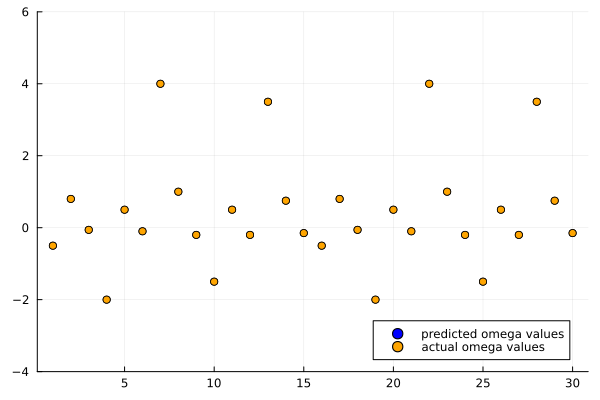

In [33]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [439]:
model.a_tau_prior

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [440]:
model.b_tau_prior

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]

In [441]:
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))
end
(model.b_tau_prior[2][2][1][1] + 1/2 * est) / (25 + model.a_tau_prior[2][2][1][1] + 1)

0.0449975722238702

In [442]:
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))
end
(1/2 * est) / (25)

0.05179504733669521

In [483]:
a = S/2
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))^2
end
(model.b_tau_prior[2][2][1][1] * (a - 1) + (a - 1)/2 * est) / (model.a_tau_prior[2][2][1][1] + 1 + S/2)

0.4798817361766747

In [484]:
a = S/2
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))^2
end
((a - 1)/2 * est) / (S/2)

0.018958741800416245

In [457]:
rand(InverseGamma(25, 1))

0.06660945577445676

**Estimating full TDCM model**

In [128]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 12 threads


In [129]:
# Initialize tau distribution
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.a_tau_star[k][t][1][feature] = 50
                model.b_tau_star[k][t][1][feature] = 2
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.a_tau_star[k][t][z + 1][feature] = 50
                    model.b_tau_star[k][t][z + 1][feature] = 2
                end
            end
        end
    end
end

In [130]:
# Initialize small tau values
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = 3
#                 model.b_tau_star[k][t][1][feature] = 3
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = 3
#                     model.b_tau_star[k][t][z + 1][feature] = 3
#                 end
#             end
#         end
#     end
# end

# Initialize random gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= 2.0
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s]
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= 2.0
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s]
                end
            end
        end
    end
end

# Initialize attribute profiles as no masteries
# for i in 1:N
#     for t in 1:O
#         model.pi_star[i][t] .= [0.4, 0.2, 0.2, 0.2]
#     end
# end

# Initialize betas in the correct direction
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]/5
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [131]:
for iter in 1:100
    update_categorical_variational_distribution(model, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 1)
    end

    update_categorical_variational_distribution2(model, 2, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 2)
    end

    update_normal_variational_distribution(model, init_step = .005, maxiter = 10, verbose = false)
    sample_β(model)

    update_normal_variational_distribution2(model, init_step = .01, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end

    update_normal_variational_distribution3(model, init_step = .05, maxiter = 100, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_ω(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_ω(model, k, t, z, feature)
                    end
                end
            end
        end
    end

    update_inverse_gamma_distribution(model, step = 1e-5, maxiter = 1, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_τ(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_τ(model, k, t, z, feature)
                    end
                end
            end
        end
    end
end

In [132]:
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)

preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [133]:
accuracy

0.851

In [134]:
attribute_accs

8-element Vector{Float64}:
 0.9914893617021276
 0.8504983388704319
 0.31076923076923074
 0.5408163265306123
 0.6953405017921147
 0.6724738675958188
 0.7566137566137566
 0.9624413145539906

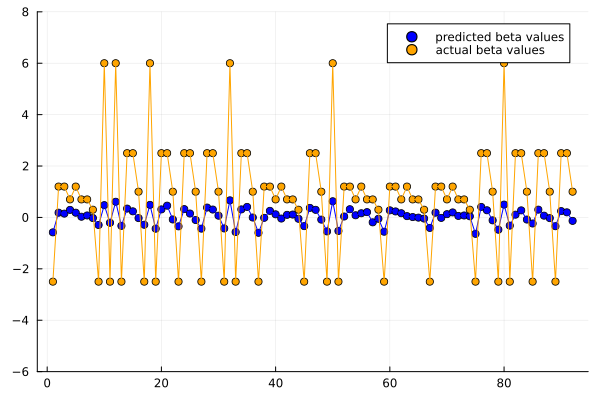

In [135]:
pred_beta_values = []
actual_beta_values = []
for j in 1:21
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
plot!(x, pred_beta_values, label = "", lc=:blue)
plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-6, 8)

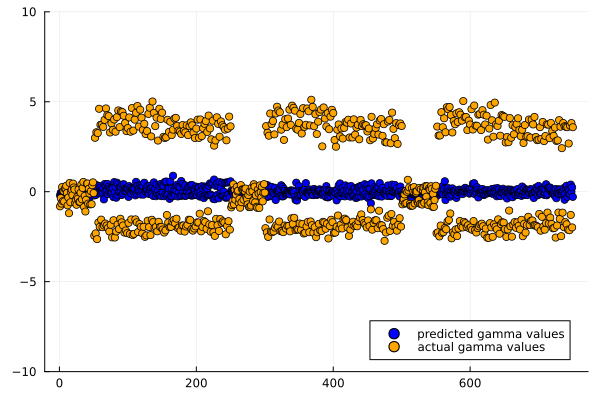

In [136]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-10, 10)

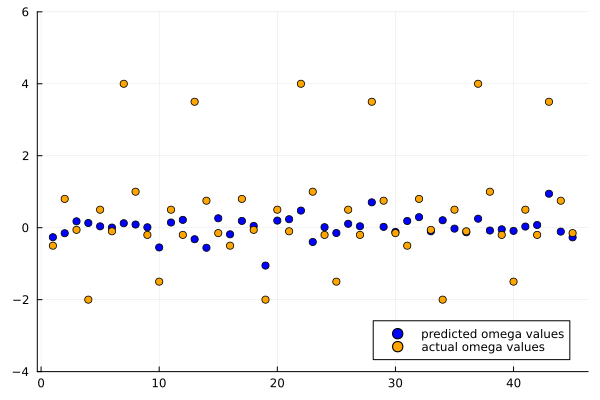

In [137]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [518]:
model.a_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[50.0]], [[50.0, 50.0], [50.0, 50.0]]]
 [[[50.0]], [[50.0, 50.0], [50.0, 50.0]]]
 [[[50.0]], [[50.0, 50.0], [50.0, 50.0]]]

In [519]:
model.b_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[2.0]], [[2.0, 2.0], [2.0, 2.0]]]
 [[[2.0]], [[2.0, 2.0], [2.0, 2.0]]]
 [[[2.0]], [[2.0, 2.0], [2.0, 2.0]]]

In [520]:
model.tau_sample

3-element Vector{Vector{Vector{Vector{Vector{Float64}}}}}:
 [[[[0.03480267915379762, 0.04111476526107702, 0.05202068753430606, 0.05072846903265691, 0.049786895368256034, 0.0446376945910719, 0.04019188979730506, 0.03799850837345206, 0.04231207903913739, 0.045633832295006796  …  0.0343382475298302, 0.03901760000751086, 0.033043316373645104, 0.04457541710756391, 0.04476332931140341, 0.041801506218354295, 0.03617521266025158, 0.0408823781376642, 0.03594860777492433, 0.03575438184596282]]], [[[0.041860110950902106, 0.041301886832169, 0.0420674969602569, 0.05532036263358305, 0.03935376636391569, 0.03558625425317548, 0.03994508180722043, 0.033794825848896246, 0.04597357423552699, 0.04034580171419195  …  0.04727975851337703, 0.045390119564538346, 0.038885765241847, 0.03761901260517699, 0.033295041360936875, 0.04227139316677181, 0.0368626272493124, 0.033129044327320625, 0.042901489517817346, 0.04094031167127002], [0.043655161178479666, 0.04142228429732911, 0.037094447698813496, 0.04534713990952

In [138]:
model.V_gamma_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.0035999999999999106;;], [0.06759999999999966;;], [0.0015999999999999396;;], [0.0035999999999999106;;], [16.974399999999633;;], [0.1295999999999996;;], [0.19359999999999955;;], [0.04839999999999969;;], [0.10239999999999962;;], [13.542399999999743;;]  …  [0.003599999999999909;;], [0.0003999999999999702;;], [0.032399999999999735;;], [0.05759999999999968;;], [0.025599999999999762;;], [0.025599999999999762;;], [0.00999999999999985;;], [0.07839999999999964;;], [0.032399999999999735;;], [5.879021525863562e-31;;]]], [[[1.0790785559879001 0.8262763090986932; 0.8262763090986932 0.6362373742322497], [0.4254937192433701 0.04863453590044005; 0.04863453590044005 0.0070245058436924105], [0.0003635403390612884 -0.006601380747127968; -0.006601380747127968 0.19863087302126747], [0.03727988315310328 -0.06734418411427173; -0.06734418411427173 0.6036082253308502], [15.204480828936763 2.0999707893955817; 2.0999707893955817 19.491819685401488]